## Models used for training

The goal of this notebook is to present few methods we used to predict pipe failure probabilities.

In [20]:
import functions

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss,average_precision_score,roc_curve,precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from imblearn.over_sampling import  SMOTE
from sklearn.ensemble import AdaBoostClassifier

In [21]:
train,test,y_train=functions.load()

In [22]:
#Preprocessing and Feature engineering
train=functions.feature_engineering(train)
train=functions.preprocess(train)

In [37]:
#creating a train set, a cross validation set and a test set. (60%/20%/20%)
#we use train_test_split method twice
x, test, y, y_test = train_test_split(train,y_train,test_size=0.2,train_size=0.8)
train, validate, y_train, y_validate = train_test_split(x,y,test_size = 0.25,train_size =0.75)

## Simple Anomaly Detection Algorithm

We use only the quantitative features, we fit mixtures of gaussian. We try to detect outliers that would fit the density estimated with gaussian mixtures. Here small probabilities should be assign to outliers, so we must take the complementary probability to detect outliers. 

In [38]:
#lets seperate our risky pipes and our safe pipes

quant_features=['Length',"YearConstruction"]
train_quant=train[quant_features]
validate_quant=validate[quant_features]

index_fail=y_train.index[(y_train["2014"]==1) | (y_train["2015"]==1)].tolist()
index_already_failed=train.index[train["NoFail"]==0]

index_safe=[x for x in y_train.index.tolist() if x not in (index_fail and index_already_failed)]

In [40]:
#we will try to fit the model only using the safe pipes, then small probabilities would be considered as outliers
train_quant_safe=train_quant.loc[index_safe]
y_train_safe=y_train.loc[index_safe]

#2014
model1=GaussianMixture(n_components=4,covariance_type='full',init_params="kmeans")
gmm=model1.fit(train_quant_safe,y_train_safe["2014"])

ypred_2014=model1.predict_proba(validate_quant)[:,1]
#complementary probability.
ypred_2014=1-ypred_2014

model2=GaussianMixture(n_components=4,covariance_type='full')
gmm=model2.fit(train_quant_safe,y_train_safe["2015"])
ypred_2015=model2.predict_proba(validate_quant)[:,1]
#complementary probability.
ypred_2015=1-ypred_2015

print("ROC_AUC 2014={:.3}".format(roc_auc_score(y_validate["2014"],ypred_2014)))
print("ROC_AUC 2015={:.3}".format(roc_auc_score(y_validate["2015"],ypred_2015)))

ROC_AUC 2014=0.778
ROC_AUC 2015=0.768


Looks like our model is very unstable and depends a lot on the initialization. We tried to work more on this approach and at the end were getting a stable 80% ROC-AUC.

## Naive Logistique Regression

In [41]:
year="2014"
LR=LogisticRegression()
LR.fit(train,y_train[year])
y_pred=LR.predict_proba(validate)

print("ROC_AUC= {:.3}".format(roc_auc_score(y_validate[year],y_pred[:,1])))
print("Average_precision_score={:.3}".format(average_precision_score(y_validate[year],y_pred[:,1])))

ROC_AUC= 0.87
Average_precision_score=0.13


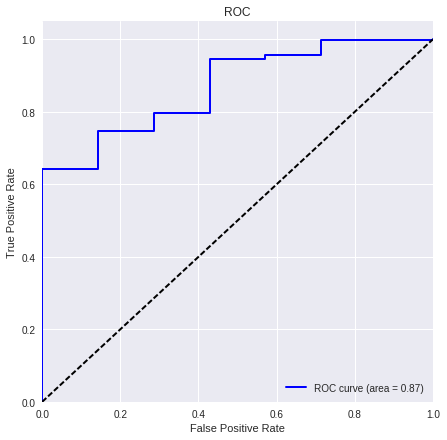

In [42]:
#we can plot the ROC curve.
fpr,tpr,roc_auc_d=functions.roc_plot_utils(y_pred,y_validate[year])

plt.figure(figsize=(7,7));
lw = 2
plt.plot(fpr[0], tpr[0], color='blue',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_d[0])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC');
plt.legend(loc="lower right")
plt.show()

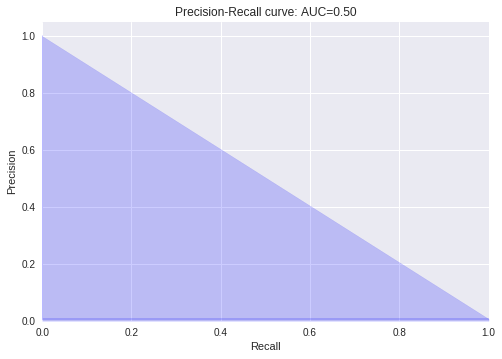

In [43]:
precision, recall, _ = precision_recall_curve(y_validate["2014"], ypred_2014)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision_score(y_validate["2014"], ypred_2014)))
plt.show()

Already a nice result with respect to ROC-AUC metric

In [44]:
#we use the weight calculated in Exploratory Analysis.
LR_balanced=LogisticRegression(class_weight={0:0.0027,1:0.9973})
LR_balanced.fit(train,y_train["2014"])
y_pred=LR_balanced.predict_proba(validate)

print("ROC_AUC= {}".format(roc_auc_score(y_validate["2014"],y_pred[:,1])))

ROC_AUC= 0.9266043766904353


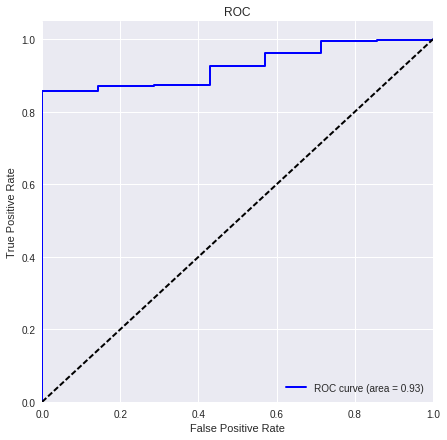

In [45]:
#ROC curve.
fpr,tpr,roc_auc_d=functions.roc_plot_utils(y_pred,y_validate[year])

plt.figure(figsize=(7,7));
lw = 2
plt.plot(fpr[0], tpr[0], color='blue',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_d[0])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC');
plt.legend(loc="lower right")
plt.show()

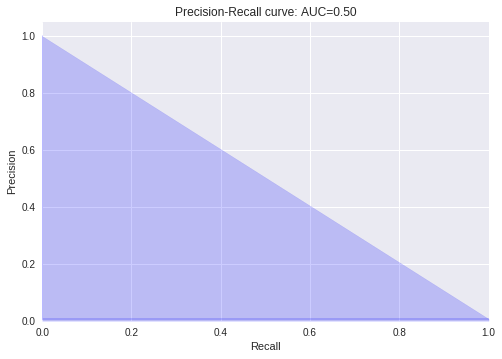

In [46]:
precision, recall, _ = precision_recall_curve(y_validate["2014"], ypred_2014)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision_score(y_validate["2014"], ypred_2014)))
plt.show()

We made a small improvement. We should do it more times using KFold strategy for example.

## Subsampling

Before trying oversampling methods can we try some kind of subsampling ? We select mini-batch with balanced classes and update our weights iteratevely using logistic regression model.

In [48]:
niter=400
year="2014"

index_fail=y_train.index[(y_train[year]==1)].tolist()

#warm_start=True to reuse coefficients of previous iteration.
LR_sub=LogisticRegression(warm_start=True,solver="newton-cg")


#we will keep this indexes everytime in the minibatch.
for i in range(niter):
    index_safe_sample=random.sample([x for x in y_train.index.tolist() if x not in index_fail], len(index_fail))
    mini_batch=index_fail+index_safe_sample
    LR_sub.fit(train.loc[mini_batch],y_train.loc[mini_batch][year])
    
    if(i%100==0):
        print("({})Train ROC_AUC: {:.4}".format(int(i/100),roc_auc_score(y_train[year],LR_sub.predict_proba(train)[:,1])),
              " Cross-Validation ROC_AUC: {:.4}\n".format(roc_auc_score(y_validate[year],LR_sub.predict_proba(validate)[:,1])),
             "  Train Log_Loss: {:.4}\n".format(log_loss(y_train[year],LR_sub.predict_proba(train)[:,1])))

(0)Train ROC_AUC: 0.894  Cross-Validation ROC_AUC: 0.9221
   Train Log_Loss: 0.5687

(1)Train ROC_AUC: 0.9073  Cross-Validation ROC_AUC: 0.9388
   Train Log_Loss: 0.659

(2)Train ROC_AUC: 0.9042  Cross-Validation ROC_AUC: 0.9254
   Train Log_Loss: 0.6188

(3)Train ROC_AUC: 0.8892  Cross-Validation ROC_AUC: 0.9162
   Train Log_Loss: 0.6789



Let's try oversampling methods. Smote is a good way to sample synthetise data and not just dupplicate minority class. 

## Oversampling with Smote

In [49]:
year="2014"

sm = SMOTE(random_state=42)
X_smote_year, y_smote_year= sm.fit_sample(train, y_train[year])

LR=LogisticRegression()
LR.fit(X_smote_year,y_smote_year)

ypred_2014=LR.predict_proba(validate)[:,1]
print("ROC_AUC= {:.3}".format(roc_auc_score(y_validate[year],ypred_2014)))

year="2015"

sm = SMOTE(random_state=42)
X_smote_year, y_smote_year= sm.fit_sample(train, y_train[year])

LR=LogisticRegression()
LR.fit(X_smote_year,y_smote_year)

ypred_2015=LR.predict_proba(validate)[:,1]
print("ROC_AUC= {:.3}".format(roc_auc_score(y_validate[year],ypred_2015)))

yfinal=np.array([ypred_2014,ypred_2015]).T
yfinal=pd.DataFrame(yfinal,columns=["2014","2015"])
print("Challenge Metric ROC_AUC= {:.3}".format(functions.metric_challenge(y_validate,yfinal)))

ROC_AUC= 0.911
ROC_AUC= 0.919
Challenge Metric ROC_AUC= 0.914


In [50]:
#Adaboost: tries to put more weight on pipes that are harder to classify.

year="2014"

sm = SMOTE(random_state=42)
X_smote_year, y_smote_year= sm.fit_sample(train, y_train[year])

adb2014=AdaBoostClassifier(n_estimators=14)
adb2014.fit(X_smote_year,y_smote_year)

ypred_2014=adb2014.predict_proba(validate)
print("ROC_AUC= {:.3}".format(roc_auc_score(y_validate[year],ypred_2014[:,1])))

year="2015"

sm = SMOTE(random_state=42)
X_smote_year, y_smote_year= sm.fit_sample(train, y_train[year])

adb2015=AdaBoostClassifier(n_estimators=20)
adb2015.fit(X_smote_year,y_smote_year)

ypred_2015=adb2015.predict_proba(validate)
print("ROC_AUC= {:.3}".format(roc_auc_score(y_validate[year],ypred_2015[:,1])))

yfinal=np.array([ypred_2014[:,1],ypred_2015[:,1]]).T
yfinal=pd.DataFrame(yfinal,columns=["2014","2015"])
print("Challenge Metric ROC_AUC= {:.3}".format(functions.metric_challenge(y_validate,yfinal)))

ROC_AUC= 0.915
ROC_AUC= 0.76
Challenge Metric ROC_AUC= 0.853


Feature ranking:
1 D 0.357
2 Length 0.214
3 Feature3 0.143
4 O 0.0714
5 IAB 0.0714
6 T 0.0714
7 YearLastFailureObserved 0.0714
8 NoFail 0.0
9 M 0.0
10 Dr 0.0
11 TimeToFailure 0.0
12 YearConstruction 0.0


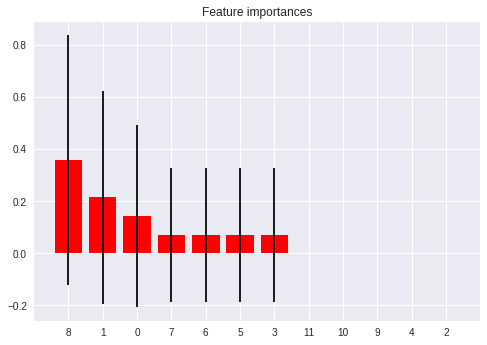

In [54]:
#Feature importance
importances = adb2014.feature_importances_
std = np.std([tree.feature_importances_ for tree in adb2014.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col_name_dict=dict(zip(list(range(len(train.columns))),train.columns))
# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("{} {} {:.3}".format(f + 1,col_name_dict[indices[f]], importances[indices[f]]),)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

We could drop features with 0.0 importance value to reduce overfitting.

## TEST

In [55]:
#Test
year="2014"
ypred_2014=adb2014.predict_proba(test)

print("ROC_AUC= {:.3}".format(roc_auc_score(y_test[year],ypred_2014[:,1])))

year="2015"
ypred_2015=LR.predict_proba(test)
print("ROC_AUC= {:.3}".format(roc_auc_score(y_test[year],ypred_2015[:,1])))

yfinal=np.array([ypred_2014[:,1],ypred_2015[:,1]]).T
yfinal=pd.DataFrame(yfinal,columns=["2014","2015"])
print("Challenge Metric ROC_AUC= {:.3}".format(functions.metric_challenge(y_test,yfinal)))

ROC_AUC= 0.811
ROC_AUC= 0.696
Challenge Metric ROC_AUC= 0.765


Our best prediction was obtain using ensemble learning and the VotingClassifier of sklearn. We already had a few classifiers that were performing well (in term of ROC-AUC) so we decided to combine them. It really improved our result.

## Submission part for LeaderBoard

In [ ]:
train,test,y_train=functions.load()
#Preprocessing and Feature engineering Train
train=functions.feature_engineering(train)
train=functions.preprocess(train)

#Preprocessing and Feature engineering Test
test=functions.feature_engineering(test)
test=functions.preprocess(test)

In [ ]:
#Training
year="2014"
adb=AdaBoostClassifier(n_estimators=20)
adb.fit(train,y_train[year])
ysub2014=adb.predict_proba(test)[:,1]

year="2015"
adb=AdaBoostClassifier(n_estimators=20)
adb.fit(train,y_train[year])
ysub2015=adb.predict_proba(test)[:,1]

In [ ]:
ysub=np.array([ysub2014,ysub2015]).T
ysub=pd.DataFrame(ysub,columns=["2014","2015"])
ysub.to_csv("smote_adaboost.csv")